### Файл train.ipynb
Тетрадка с кодом обучения модели,
которая при запуске Run без дополнительных
модификаций, позволяет получить ту же самую
модель, которая используется для прогноза в
следующем ноутбуке (main.ipynb).

In [1]:
!git clone https://github.com/samoletpanfilov/reinforcement_task.git

fatal: destination path 'reinforcement_task' already exists and is not an empty directory.


### Установка зависимостей

In [2]:
!pip install tsfresh catboost

### Импорт библиотек

In [3]:
import pandas as pd
import numpy as np
import requests
import os
from io import BytesIO
import shutil
import re
import warnings
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from catboost import CatBoostRegressor
import xgboost as xgb

from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import settings

import pickle
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)

### Загрузка данных

In [4]:
def load_merge_data():
    df_train = pd.read_excel("/content/reinforcement_task/data/train.xlsx").rename(columns={"dt": "timestamp", "Цена на арматуру": "target"})
    df_chmf = pd.read_csv("/content/reinforcement_task/data/CHMF Акции.csv").rename(columns={"Date": "timestamp"})
    df_magn = pd.read_csv("/content/reinforcement_task/data/MAGN Акции.csv").rename(columns={"Дата": "timestamp"})
    df_nlmk = pd.read_csv("/content/reinforcement_task/data/NLMK Акции.csv").rename(columns={"Date": "timestamp"})
    df_transfer = pd.read_excel("/content/reinforcement_task/data/Грузоперевозки.xlsx").rename(columns={"dt": "timestamp", "Индекс стоимости грузоперевозок": "transfer_cost"})
    df_market = pd.read_excel("/content/reinforcement_task/data/Данные рынка стройматериалов.xlsx").rename(columns={"dt": "timestamp"})
    df_lme = pd.read_excel("/content/reinforcement_task/data/Индекс LME.xlsx").rename(columns={"дата": "timestamp"})
    df_macro = pd.read_excel("/content/reinforcement_task/data/Макропоказатели.xlsx").rename(columns={"dt": "timestamp"})
    df_fuel = pd.read_excel("/content/reinforcement_task/data/Топливо.xlsx").rename(columns={"dt": "timestamp"})
    df_raw_prices = pd.read_excel("/content/reinforcement_task/data/Цены на сырье.xlsx").rename(columns={"dt": "timestamp"})

    df_chmf["timestamp"] = pd.to_datetime(df_chmf["timestamp"])
    df_magn["timestamp"] = pd.to_datetime(df_magn["timestamp"])
    df_nlmk["timestamp"] = pd.to_datetime(df_nlmk["timestamp"])

    merged_df = pd.merge(df_train, df_chmf, on='timestamp', how='outer')
    merged_df = pd.merge(merged_df, df_magn, on='timestamp', how='outer')
    merged_df = pd.merge(merged_df, df_nlmk, on='timestamp', how='outer')
    merged_df = pd.merge(merged_df, df_transfer, on='timestamp', how='outer')
    merged_df = pd.merge(merged_df, df_market, on='timestamp', how='outer')
    merged_df = pd.merge(merged_df, df_lme, on='timestamp', how='outer')
    merged_df = pd.merge(merged_df, df_macro, on='timestamp', how='outer')
    merged_df = pd.merge(merged_df, df_fuel, on='timestamp', how='outer')
    merged_df = pd.merge(merged_df, df_raw_prices, on='timestamp', how='outer')

    merged_df.sort_values("timestamp", inplace=True)

    return merged_df

test = pd.read_excel("/content/reinforcement_task/data/test.xlsx")
train = pd.read_excel("/content/reinforcement_task/data/train.xlsx")
sample_submission = pd.read_excel("/content/reinforcement_task/sample_submission.xlsx")

# Подготовка данных и генерация признаков

In [5]:
# Подготовка тренировочной выборки
df_train = pd.DataFrame()
df_train['Date'] = pd.to_datetime(train['dt'])
df_train['Price'] = train['Цена на арматуру']
df_train['istest'] = 0

# Подготовка тестовой выборки
df_test = pd.DataFrame()
df_test['Date'] = pd.to_datetime(test['dt'])
df_test['Price'] = test['Цена на арматуру']
df_test['istest'] = 1

# Конкатенация в один датасет с меткой `istest`
raw = pd.concat((df_train, df_test)).reset_index(drop=True)

# Выделение временных признаков
raw["day_sin"] = np.sin(raw["Date"].dt.day)
raw["day_cos"] = np.cos(raw["Date"].dt.day)

# Посмотрим на тип переменных
raw.dtypes

,0
Date,datetime64[ns]
Price,int64
istest,int64
day_sin,float64
day_cos,float64


In [6]:
raw.head(7)

,Date,Price,istest,day_sin,day_cos
0,2015-01-05,32900,0,-0.958924,0.283662
1,2015-01-12,32500,0,-0.536573,0.843854
2,2015-01-19,32000,0,0.149877,0.988705
3,2015-01-26,30700,0,0.762558,0.646919
4,2015-02-02,30300,0,0.909297,-0.416147
5,2015-02-09,30300,0,0.412118,-0.911130
6,2015-02-16,30100,0,-0.287903,-0.957659


In [7]:
# Создадим матрицы со сдвигом, то есть сделаем так, чтобы значение
# цены на следующую неделю являлось "неизвестным для модели"
X = raw.drop(columns=['Price']).iloc[:-1, :]
y = raw['Price'].values[1:]
X['Price_target'] = y
X['Price_source'] = raw['Price'].values[:-1]

# Подсчет разницы между текущим и прошлым значением цены на покупку арматуры
price_diff = X['Price_source'] - X['Price_target']

# Удаление первой строки
X = X.drop([0])

# Добавление разницы в цене
X['Price_Diff'] = price_diff.values[:-1]

In [8]:
# Посмотрим на конец тренировочной выборки
X[X['istest'] == 0].tail()

,Date,istest,day_sin,day_cos,Price_target,Price_source,Price_Diff
395,2022-08-01,0,0.841471,0.540302,49000,47500,0
396,2022-08-08,0,0.989358,-0.145500,47500,49000,-1500
397,2022-08-15,0,0.650288,-0.759688,46500,47500,1500
398,2022-08-22,0,-0.008851,-0.999961,46000,46500,1000
399,2022-08-29,0,-0.663634,-0.748058,46000,46000,500


In [9]:
# Посмотрим на начало тестовой выборки
X[X['istest'] == 1].head()

,Date,istest,day_sin,day_cos,Price_target,Price_source,Price_Diff
400,2022-09-05,1,-0.958924,0.283662,46000,46000,0
401,2022-09-12,1,-0.536573,0.843854,46000,46000,0
402,2022-09-19,1,0.149877,0.988705,45500,46000,0
403,2022-09-26,1,0.762558,0.646919,45500,45500,500
404,2022-10-03,1,0.141120,-0.989992,45000,45500,0


In [10]:
# Удаление ненужных столбцов
y = X['Price_target']
X = X.drop(columns=['Price_target', 'Date'])

# Используем tsfresh для генерации признаков

In [11]:
# Используем следующий набор параметров

# Рассчитываются коэффициенты skewness и kurtosis, считается, сколько раз
# повторялось значение минимума и максимума, различные квантили, оконные
# статистики, автокорреляции и т. д.
settings_efficient = settings.EfficientFCParameters()
len(settings_efficient)

73

In [12]:
# Подготовка фреймов длины 5

data_fot_tsfresh = X['Price_source'].values
indexes = list(range(len(data_fot_tsfresh), 4, -1))

ts_for_tsfresh = []

for i in range(len(indexes)):
    indexes_ts = indexes[i:i+6][::-1]
    values_ts = data_fot_tsfresh[indexes_ts[0]:indexes_ts[-1]]
    # print(values_ts)
    if len(values_ts) < 5:
        break
    ts_for_tsfresh.append(values_ts)

ts_for_tsfresh = pd.DataFrame(ts_for_tsfresh[::-1])

In [13]:
# Создание фрейма необходимого формата для выделения признаков
data_long = pd.DataFrame({'data': ts_for_tsfresh.values.flatten(),
              'id': np.repeat(np.array(ts_for_tsfresh.index), 5)})

In [14]:
# Генерация признаков
X_tsfresh = extract_features(data_long, column_id='id', impute_function=impute, default_fc_parameters=settings_efficient)

Feature Extraction: 100%|██████████| 417/417 [00:44<00:00,  9.28it/s]


In [15]:
# Удаление пустых строк
X = X.drop(list(range(1, 10)))
y = y.drop(list(range(1, 10)))

# Reset индексов
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

In [16]:
# Добавляем выделенные признаки в тренировочную и тестовую выборки
for col in X_tsfresh.columns:
    X[col] = X_tsfresh[col]

In [17]:
X.head(12)

istest   day_sin   day_cos  Price_source  Price_Diff  \
0        0 -0.287903 -0.957659         28700         300   
1        0 -0.846220 -0.532833         27800         900   
2        0 -0.988032  0.154251         27200         600   
3        0 -0.279415  0.960170         26600         600   
4        0  0.420167  0.907447         25700         900   
5        0  0.912945  0.408082         24800         900   
6        0  0.956376 -0.292139         24700         100   
7        0 -0.756802 -0.653644         24300         400   
8        0 -0.999990  0.004426         23900         400   
9        0 -0.750987  0.660317         24000        -100   
10       0 -0.132352  0.991203         23700         300   
11       0  0.841471  0.540302         23500         200   

    data__variance_larger_than_standard_deviation  data__has_duplicate_max  \
0                                             1.0                      0.0   
1                                             1.0                      0.0   
2                                             1.0                      0.0   
3                                             1.0                      0.0   
4                                             1.0                      0.0   
5                                             1.0                      0.0   
6                                             1.0                      0.0   
7                                             1.0                      0.0   
8                                             1.0                      0.0   
9                                             1.0                      0.0   
10                                            1.0                      0.0   
11                                            1.0                      0.0   

    data__has_duplicate_min  data__has_duplicate  data__sum_values  \
0                       0.0                  0.0          146400.0   
1                       0.0                  0.0          144100.0   
2                       0.0                  0.0          141900.0   
3                       0.0                  0.0          139300.0   
4                       0.0                  0.0          136000.0   
5                       0.0                  0.0          132100.0   
6                       0.0                  0.0          129000.0   
7                       0.0                  0.0          126100.0   
8                       0.0                  0.0          123400.0   
9                       0.0                  0.0          121700.0   
10                      0.0                  0.0          120600.0   
11                      0.0                  0.0          119400.0   

    data__abs_energy  data__mean_abs_change  data__mean_change  \
0       4.287700e+09                  350.0             -350.0   
1       4.154530e+09                  400.0             -400.0   
2       4.030010e+09                  500.0             -500.0   
3       3.884930e+09                  600.0             -600.0   
4       3.704420e+09                  750.0             -750.0   
5       3.495770e+09                  750.0             -750.0   
6       3.333020e+09                  625.0             -625.0   
7       3.183670e+09                  575.0             -575.0   
8       3.047320e+09                  450.0             -450.0   
9       2.962830e+09                  250.0             -200.0   
10      2.909480e+09                  300.0             -250.0   
11      2.851640e+09                  250.0             -200.0   

    data__mean_second_derivative_central  data__median  data__mean  \
0                              66.666667       29200.0     29280.0   
1                            -116.666667       29000.0     28820.0   
2                             -66.666667       28700.0     28380.0   
3                             -50.000000       27800.0     27860.0   
4                               0.000000       27200.0     27200.0   
5                 

# Обучение моделей XGBoost

In [18]:
# Разделение тренировочной выборки на обучающую и отложенную выборки

# Маска для тренировочной выборки
X_for_train = (X['istest'] == 0)

X_train, X_holdout, y_train, y_holdout = train_test_split(X[X_for_train].drop(columns=['istest']),
                                                          y[X_for_train], test_size=0.2, shuffle=False)

In [19]:
params = {
    'tree_method': "hist",
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'max_leaves': 31,
    'subsample': 0.60,
    'colsample_bytree': 0.50,
    'n_jobs': 2,
    'eval_metric': 'mae',
    'enable_categorical': True
}

# Инициализация модели №1 и её параметров
model0 = xgb.XGBRegressor(
    **params,
    random_state=17
)

# Инициализация модели №2 и её параметров
model1 = xgb.XGBRegressor(
    **params,
    random_state=25,
)

# Инициализация модели №3 и её параметров
model2 = xgb.XGBRegressor(
    **params,
    random_state=32,
)

In [20]:
# Обучение модели №1
model0.fit(
    X_train,
    y_train,
)

# Обучение модели №2
model1.fit(
    X_train,
    y_train,
)

# Обучение модели №3
model2.fit(
    X_train,
    y_train,
)

# Предсказывание значений на отложенной выборке
ypred = (model0.predict(X_holdout) +
         model1.predict(X_holdout) +
         model2.predict(X_holdout)) / 3

### Проверка на отложенной выборке

In [21]:
result = pd.DataFrame({'real': y_holdout[1:],
              'pred': ypred[:-1]})
result['error'] = result['real'] - result['pred']
result.tail(12)

,real,pred,error
378,43000,45515.593750,-2515.593750
379,44000,44450.433594,-450.433594
380,45000,42993.738281,2006.261719
381,45500,44001.671875,1498.328125
382,47000,46815.121094,184.878906
383,47500,45975.488281,1524.511719
384,47500,47642.144531,-142.144531
385,49000,47388.386719,1611.613281
386,47500,47064.609375,435.390625
387,46500,52236.890625,-5736.890625


In [22]:
# Подсчет метрик прогноза на отложенной выборке
print("MAE на holdout-выборке:", mean_absolute_error(y_holdout, ypred))
print("MSE на holdout-выборке:", mean_squared_error(y_holdout, ypred))

MAE на holdout-выборке: 7444.08251953125
MSE на holdout-выборке: 85541640.0


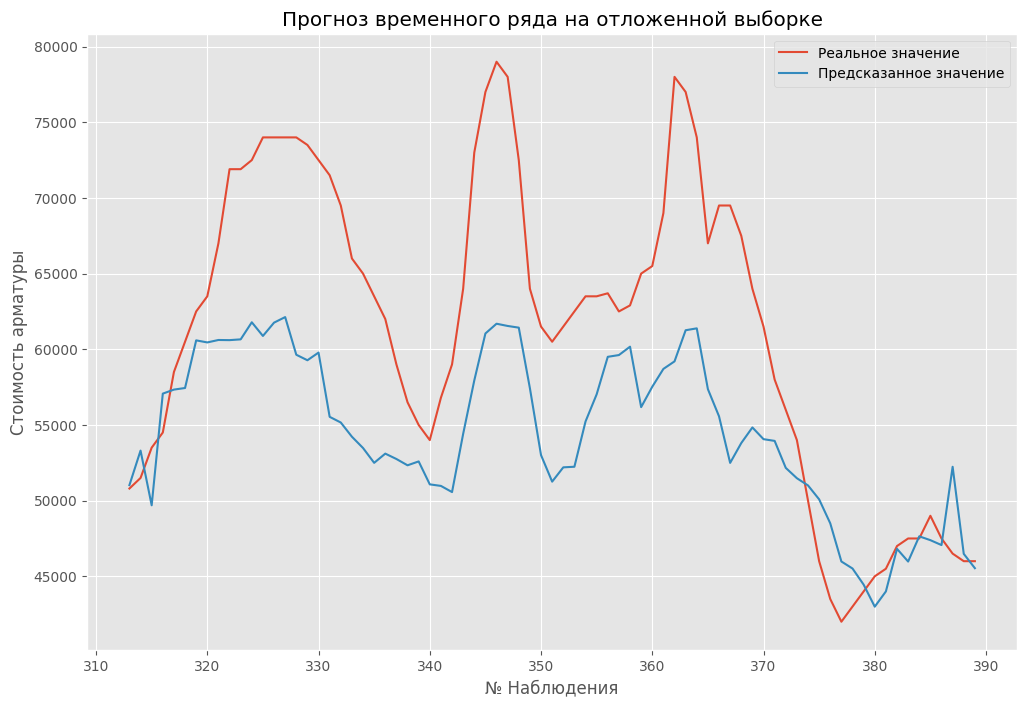

In [23]:
from matplotlib.pyplot import figure
figure(figsize=(12, 8), dpi=100)


plt.plot(result['real'], label='Реальное значение');
plt.plot(result['pred'], label='Предсказанное значение');
plt.title('Прогноз временного ряда на отложенной выборке')
plt.xlabel('№ Наблюдения')
plt.ylabel('Стоимость арматуры')
plt.legend();

# Обучение на всей тренировочной выборке

In [24]:
# Обучение модели №1
model0.fit(
    X[X_for_train].drop(columns=['istest']),
    y[X_for_train],
)

# Обучение модели №2
model1.fit(
    X[X_for_train].drop(columns=['istest']),
    y[X_for_train],
)

# Обучение модели №3
model2.fit(
    X[X_for_train].drop(columns=['istest']),
    y[X_for_train],
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric='mae', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=31,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=2,
             num_parallel_tree=None, random_state=32, ...)

### Сохраняем веса моделей

In [25]:
pickle.dump(model0, open("xgb_reg1.pkl", "wb"))
pickle.dump(model1, open("xgb_reg2.pkl", "wb"))
pickle.dump(model2, open("xgb_reg3.pkl", "wb"))